# 1 - Récupération des données

Les réglementations étant assez vastes, nous allons dans un premier temps nous concentrer sur les réglementations liées à la sécurité incendie.

Cette dernière est propre aux types d'ouvrages construits parmi lesquels nous retrouvons :
- les ERT ou établissement recevant des travailleurs
- les ERP ou établissement recevant du publics
- les batiments d'habitation
(etc) et tous ont leurs propres lois et décrets.

In [15]:
# Import des bibliothèques

import pandas as pd
import numpy as np
import dateparser

import requests
import re
from bs4 import BeautifulSoup

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

In [67]:
pip install dateparser

  Using cached dateparser-1.2.0-py2.py3-none-any.whl.metadata (28 kB)
Using cached dateparser-1.2.0-py2.py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1-1 Récupération des données du Code du travail (ERT)

### 1-1-1 Scrapping de Legifrance

In [16]:
url = "https://www.legifrance.gouv.fr/codes/section_lc/LEGITEXT000006072050/LEGISCTA000018488606/#LEGISCTA000018532586"
# url = "https://www.legifrance.gouv.fr/codes/section_lc/LEGITEXT000006074096/LEGISCTA000006112857/#LEGISCTA000006112857"

def process_line(text):
    text = text.replace('R. ', ' R. ')
    text = re.sub(r'([;:°])(\s*[0-9a-zA-Z])', r'\1 \2', text)
    text = re.sub(r'\)(\s*[0-9a-zA-Z])', r') \1', text)
    text = re.sub(r'\.(?=\s*[A-Z])', '. ', text)
    return text

def find_cuts(text):
    positions = []
    for match in re.finditer(r'\. (?=[A-Z])', text):
        positions.append(match.start())
    return len(positions) + 1

def get_articles_limit(text):
    pattern = r'\((Articles? )?(R\d+-\d+)(?: à (R\d+-\d+))?\)'
    match = re.search(pattern, text)
    if match:
        begin_ = match.group(2) 
        end_ = match.group(3) if match.group(3) else begin_
        return begin_, end_
    else:
        return None, None

def reference_to_ID(article):
    base_3 = article[1:article.find('-')]
    base_1 = article[article.find('-')+1:]
    if base_1.find('-') ==-1:
        return 1000 * int(base_3) + int(base_1)
    else:
        base_float = base_1[base_1.find('-')+1:]
        base_1 = base_1[base_1.find('-')+1:]
        return 1000 * int(base_3) + int(base_1) + int(base_float)/100

        
def get_articles_info(article_):
    x = reference_to_ID(article_.replace('Article ', ''))
    df_tmp = df_chapters.copy()
    df_tmp[['Debut', 'Fin']] = df_tmp[['Debut', 'Fin']].map(reference_to_ID).astype(int)
    df_ = df_tmp[(df_tmp['Debut'] <= x) & (df_tmp['Fin'] >= x)].copy()
    tit = df_['Titre'].dropna().values[0]
    contenu_tit = df_['Contenu_Titre'].dropna().values[0]
    if len(df_['Chapitre'].dropna()) > 0:
        chap = df_['Chapitre'].dropna().values[0]
        contenu_chap = df_['Contenu_Chapitre'].dropna().values[0]
    else:
        chap = 1
        contenu_chap = 'Pas de Chapitre'
    if len(df_['Section'].dropna()) > 0:
        sec = df_['Section'].dropna().values[0]
        contenu_sec = df_['Contenu_Section'].dropna().values[0]
    else:
        sec = 1
        contenu_sec = 'Pas de titre'
    return tit, contenu_tit, chap, contenu_chap, sec, contenu_sec
    
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    df_chapters = pd.DataFrame(columns=['Titre', 'Chapitre', 'Section', 'Debut', 'Fin', 'Contenu Titre', 'Contenu Chapitre', 'Contenu Section'])
    for span in soup.find_all('span', {'data-anchor': True})[:-1]:
        txt = span.get_text(strip=True)
        beg, en = get_articles_limit(txt)
        for vocab in ['Titre', 'Chapitre', 'Section']:
            if txt[:len(vocab)] == vocab:
                globals()[f'Last_{vocab}'] = txt[:txt.find(':')-1]
                df_tmp = pd.DataFrame({
                    'Titre': None, 
                    'Chapitre': None,
                    'Section': None,
                    'Contenu Titre': None,
                    'Contenu Chapitre': None,
                    'Contenu Section': None,
                    'Debut': [beg], 
                    'Fin': [en],
                })
                df_tmp[f'Contenu_{vocab}'] = txt[txt.find(':')+1:].strip()
                df_tmp[vocab] = txt[:txt.find(':')-1]
                df_chapters = pd.concat([df_chapters, df_tmp])
    
    numbers_dict = ({'Ier': 1, 'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6, 'VII': 7, 'VIII': 8, 'IX': 9, 'X': 10})
    df_chapters['Titre'] = df_chapters['Titre'].map(lambda x: numbers_dict[x.replace('Titre ', '').strip()] if x else None)
    df_chapters['Chapitre'] = df_chapters['Chapitre'].map(lambda x: numbers_dict[x.replace('Chapitre ', '').strip()] if x else None)
    df_chapters['Section'] = df_chapters['Section'].map(lambda x: x.replace('Section ', '').strip() if x else None)  
    df_chapters['Titre'] = df_chapters['Titre'].ffill()
    
    articles_data = []
    for k, article in enumerate(soup.find_all('a', id=lambda x: x and x.startswith("linkLEGIARTI"))):
        article_name = article.get_text(strip=True)
        mise_en_application = article.find_next('a', href=lambda x: x and '/loda/id/' in x)
        mise_en_application_text = mise_en_application.get_text(strip=True) if mise_en_application else 'Non disponible'
        content_article = article.find_next('div', class_='content')
        if content_article:
            content = content_article.get_text(strip=True)
        else:
            content = 'Contenu non disponible'

        tit, contenu_tit, chap, contenu_chap, sec, contenu_sec = get_articles_info(article_name)
        articles_data.append({
            'N° Titre': tit,
            'Titre': contenu_tit,
            'N° Chapitre': chap,
            'Chapitre': contenu_chap,
            'N° Section': sec,
            'Section': contenu_sec,
            'Article': article_name,
            'Mise en application': mise_en_application_text,
            'Contenu': content
        })
        
    df = pd.DataFrame(articles_data)    
    df['Contenu'] = df['Contenu'].map(process_line)
    df['Nombre phrases'] = df['Contenu'].map(find_cuts)
else:
    print("Erreur lors du chargement de la page :", response.status_code)
    df['N° Titre'] = df['N° Titre'].astype(int)
    df['N° Chapitre'] = df['N° Chapitre'].astype(int)

In [29]:
df_ert=df

### 1-1-2 Analyse des données

In [17]:
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   N° Titre             299 non-null    float64
 1   Titre                299 non-null    object 
 2   N° Chapitre          299 non-null    float64
 3   Chapitre             299 non-null    object 
 4   N° Section           299 non-null    object 
 5   Section              299 non-null    object 
 6   Article              299 non-null    object 
 7   Mise en application  299 non-null    object 
 8   Contenu              299 non-null    object 
 9   Nombre phrases       299 non-null    int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 23.5+ KB


,N° Titre,Titre,N° Chapitre,Chapitre,N° Section,Section,Article,Mise en application,Contenu,Nombre phrases
count,299.000000,299,299.000000,299,299,299,299,299,299,299.000000
unique,NaN,3,NaN,16,10,54,299,31,299,NaN
top,NaN,Obligations de l'employeur pour l'utilisation ...,NaN,Risques d'incendies et d'explosions et évacuat...,2,Installations sanitaires (Articles R4228-1 à R...,Article R4211-1,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Les dispositions du présent titre déterminent,...",NaN
freq,NaN,190,NaN,56,76,18,1,211,1,NaN
mean,1.662207,NaN,5.147157,NaN,NaN,NaN,NaN,NaN,NaN,1.518395
std,0.501283,NaN,2.026275,NaN,NaN,NaN,NaN,NaN,NaN,0.769923
min,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,1.000000,NaN,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
50%,2.000000,NaN,6.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,2.000000,NaN,7.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000


In [18]:
print('Analyse d occurence des Titres du Livre II :\n', df['Titre'].value_counts())
print('\n')
print('Analyse d occurence des Chapitres :\n', df['Chapitre'].value_counts())

Analyse d occurence des Titres du Livre II :
 Titre
Obligations de l'employeur pour l'utilisation des lieux de travail  (Articles R4221-1 à R4228-37)                                                190
Obligations du maître d'ouvrage pour la conception des lieux de travail  (Articles R4211-1 à R4217-2)                                            105
Obligation de vigilance et responsabilité des maîtres d'ouvrage et des donneurs d'ordre en matière d'hébergement (Articles R4231-1 à R4231-4)      4
Name: count, dtype: int64


Analyse d occurence des Chapitres :
 Chapitre
Risques d'incendies et d'explosions et évacuation (Articles R4227-1 à R4227-57)                   56
Risques d'incendies et d'explosions et évacuation (Articles R4216-1 à R4216-34)                   37
Installations sanitaires,  restauration et hébergement (Articles R4228-1 à R4228-37)              37
Sécurité des lieux de travail (Articles R4214-1 à R4214-28)                                       28
Aération, assainissemen

In [20]:
df['Numéro Décret'] = df['Mise en application'].str.extract(r'n°(\d+-\d+)')
df.head()
# pas tout à fait vrai pour modifie le ...

,N° Titre,Titre,N° Chapitre,Chapitre,N° Section,Section,Article,Mise en application,Contenu,Nombre phrases,Numéro Décret
0,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),1,Champ d'application et définitions (Articles R...,Article R4211-1,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Les dispositions du présent titre déterminent,...",1,2008-244
1,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),1,Champ d'application et définitions (Articles R...,Article R4211-2,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Pour l'application du présent titre, on entend...",2,2008-244
2,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-3,Modifié par Décret n°2011-1461\n du 7 novembre...,Le maître d'ouvrage élabore et transmet aux ut...,2,2011-1461
3,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-4,Création Décret n°2008-244 du 7 mars 2008 - ar...,Le dossier de maintenance des lieux de travail...,1,2008-244
4,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-5,Création Décret n°2008-244 du 7 mars 2008 - ar...,Le dossier de maintenance des lieux de travail...,1,2008-244


In [22]:
df['Date decret'] = df['Mise en application'].str.extract(r'du\s+(.+?)\s+-')
df['Date decret'] = df['Date decret'].astype(str).apply(lambda x: dateparser.parse(x) if x != 'nan' else None)
df.head()

,N° Titre,Titre,N° Chapitre,Chapitre,N° Section,Section,Article,Mise en application,Contenu,Nombre phrases,Numéro Décret,Date decret
0,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),1,Champ d'application et définitions (Articles R...,Article R4211-1,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Les dispositions du présent titre déterminent,...",1,2008-244,2008-03-07
1,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),1,Champ d'application et définitions (Articles R...,Article R4211-2,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Pour l'application du présent titre, on entend...",2,2008-244,2008-03-07
2,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-3,Modifié par Décret n°2011-1461\n du 7 novembre...,Le maître d'ouvrage élabore et transmet aux ut...,2,2011-1461,2011-11-07
3,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-4,Création Décret n°2008-244 du 7 mars 2008 - ar...,Le dossier de maintenance des lieux de travail...,1,2008-244,2008-03-07
4,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-5,Création Décret n°2008-244 du 7 mars 2008 - ar...,Le dossier de maintenance des lieux de travail...,1,2008-244,2008-03-07


In [23]:
df['Annee decret'] = df['Date decret'].dt.year.fillna(0).astype(int)
df.head()

,N° Titre,Titre,N° Chapitre,Chapitre,N° Section,Section,Article,Mise en application,Contenu,Nombre phrases,Numéro Décret,Date decret,Annee decret
0,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),1,Champ d'application et définitions (Articles R...,Article R4211-1,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Les dispositions du présent titre déterminent,...",1,2008-244,2008-03-07,2008
1,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),1,Champ d'application et définitions (Articles R...,Article R4211-2,Création Décret n°2008-244 du 7 mars 2008 - ar...,"Pour l'application du présent titre, on entend...",2,2008-244,2008-03-07,2008
2,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-3,Modifié par Décret n°2011-1461\n du 7 novembre...,Le maître d'ouvrage élabore et transmet aux ut...,2,2011-1461,2011-11-07,2011
3,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-4,Création Décret n°2008-244 du 7 mars 2008 - ar...,Le dossier de maintenance des lieux de travail...,1,2008-244,2008-03-07,2008
4,1.0,Obligations du maître d'ouvrage pour la concep...,1.0,Principes généraux (Articles R4211-1 à R4211-5),2,Dossier de maintenance (Articles R4211-3 à R42...,Article R4211-5,Création Décret n°2008-244 du 7 mars 2008 - ar...,Le dossier de maintenance des lieux de travail...,1,2008-244,2008-03-07,2008


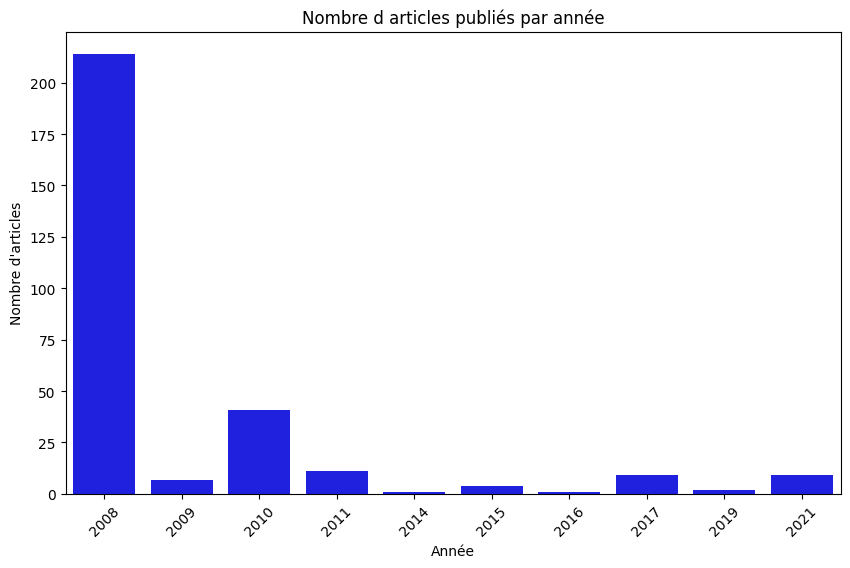

In [25]:
df['Annee decret'] = pd.Categorical(df['Annee decret'], ordered=True, categories=sorted(df['Annee decret'].unique()))

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Annee decret', color='blue')
plt.title("Nombre d articles publiés par année")
plt.xlabel("Année")
plt.ylabel("Nombre d'articles")
plt.xticks(rotation=45)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


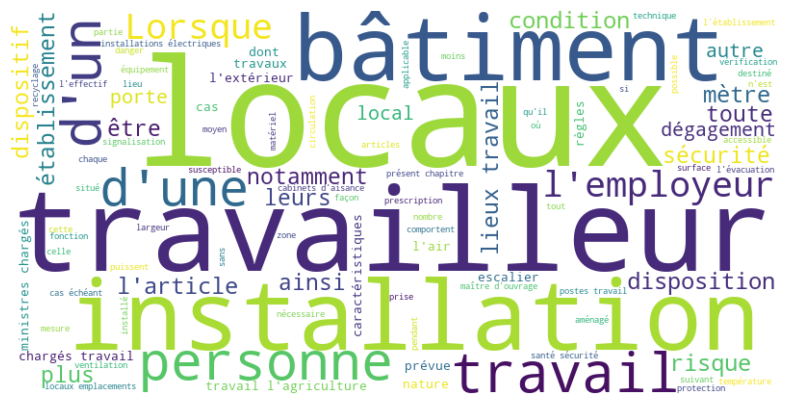

In [26]:
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

text = " ".join(str(contenu) for contenu in df['Contenu'])

filtered_text = " ".join([word for word in text.split() if word.lower() not in stop_words])

wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
# extraction des données en .csv
df.to_csv('legifrance_ert.csv', index=False, sep=";")

## 1-2 Analyse des données des Etablissements recevant du public (ERP)

## 1-3 Analyse des données du Code de la construction et de l’habitation (CCH)

### 1-3-1 Scrapping de Legifrance

In [30]:
url = "https://www.legifrance.gouv.fr/codes/section_lc/LEGITEXT000006074096/LEGISCTA000006112857/#LEGISCTA000006112857"
    
response = requests.get(url)

if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    df_chapters = pd.DataFrame(columns=['Titre', 'Chapitre', 'Section', 'Debut', 'Fin', 'Contenu Titre', 'Contenu Chapitre', 'Contenu Section'])
    for span in soup.find_all('span', {'data-anchor': True})[:-1]:
        txt = span.get_text(strip=True)
        beg, en = get_articles_limit(txt)
        for vocab in ['Titre', 'Chapitre', 'Section']:
            if txt[:len(vocab)] == vocab:
                globals()[f'Last_{vocab}'] = txt[:txt.find(':')-1]
                df_tmp = pd.DataFrame({
                    'Titre': None, 
                    'Chapitre': None,
                    'Section': None,
                    'Contenu Titre': None,
                    'Contenu Chapitre': None,
                    'Contenu Section': None,
                    'Debut': [beg], 
                    'Fin': [en],
                })
                df_tmp[f'Contenu_{vocab}'] = txt[txt.find(':')+1:].strip()
                df_tmp[vocab] = txt[:txt.find(':')-1]
                df_chapters = pd.concat([df_chapters, df_tmp])
    
    numbers_dict = ({'Ier': 1, 'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6, 'VII': 7, 'VIII': 8, 'IX': 9, 'X': 10})
    df_chapters['Titre'] = df_chapters['Titre'].map(lambda x: numbers_dict[x.replace('Titre ', '').strip()] if x else None)
    df_chapters['Chapitre'] = df_chapters['Chapitre'].map(lambda x: numbers_dict[x.replace('Chapitre ', '').strip()] if x else None)
    df_chapters['Section'] = df_chapters['Section'].map(lambda x: x.replace('Section ', '').strip() if x else None)  
    df_chapters['Titre'] = df_chapters['Titre'].ffill()
    
    articles_data = []
    for k, article in enumerate(soup.find_all('a', id=lambda x: x and x.startswith("linkLEGIARTI"))):
        article_name = article.get_text(strip=True)
        mise_en_application = article.find_next('a', href=lambda x: x and '/loda/id/' in x)
        mise_en_application_text = mise_en_application.get_text(strip=True) if mise_en_application else 'Non disponible'
        content_article = article.find_next('div', class_='content')
        if content_article:
            content = content_article.get_text(strip=True)
        else:
            content = 'Contenu non disponible'

        tit, contenu_tit, chap, contenu_chap, sec, contenu_sec = get_articles_info(article_name)
        articles_data.append({
            'N° Titre': tit,
            'Titre': contenu_tit,
            'N° Chapitre': chap,
            'Chapitre': contenu_chap,
            'N° Section': sec,
            'Section': contenu_sec,
            'Article': article_name,
            'Mise en application': mise_en_application_text,
            'Contenu': content
        })
        
    df = pd.DataFrame(articles_data)    
    df['Contenu'] = df['Contenu'].map(process_line)
    df['Nombre phrases'] = df['Contenu'].map(find_cuts)
else:
    print("Erreur lors du chargement de la page :", response.status_code)
    df['N° Titre'] = df['N° Titre'].astype(int)
    df['N° Chapitre'] = df['N° Chapitre'].astype(int)

KeyError: 'préliminaire'